In [1]:
import time
import tqdm
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
#from jupyterthemes import jtplot
#jtplot.style()

In [2]:
class Gaussian_scale_mix():
    def __init__(self, sigma1, sigma2, pi):
        self.sigma1 = torch.tensor([sigma1], dtype = torch.float)
        self.sigma2 = torch.tensor([sigma2], dtype = torch.float)
        self.pi = pi

    def log_prob(self, weight):
        sigma = self.pi*self.sigma1 + (1 - self.pi)*self.sigma2
        log_prob = float(-0.5*torch.log(2*torch.tensor([math.pi]))) - torch.log(torch.abs(sigma)) - (weight)**2/(2*sigma**2)
        return log_prob

In [3]:
class BayesLinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, sigma1, sigma2, pi, fit_prior = False):
        super(BayesLinearModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if fit_prior:
            self.sigma1 = nn.Parameter(torch.Tensor([sigma1]), requires_grad = True)
            self.sigma2 = nn.Parameter(torch.Tensor([sigma2]), requires_grad = True)
            self.pi = nn.Parameter(torch.Tensor([pi]), requires_grad = True)
        else:
            self.sigma1 = sigma1
            self.sigma2 = sigma2
            self.pi = pi
            
        self.sigma = self.pi*self.sigma1 + (1- self.pi)*self.sigma2
        
        #Initialize parameters for q(w/theta) - variational distribution float(self.sigma)
        #Weight parameters
        self.w_mu = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).normal_(0.0, float(self.sigma)), requires_grad = True)
        self.w_rho = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).normal_(0.0, float(self.sigma)), requires_grad = True)
        #self.w_rho = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).fill_(float(self.sigma)), requires_grad = True)
        
        #Bias parameters
        self.b_mu = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-1.0, 1.0), requires_grad = True) #bias mean
        self.b_rho = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-1.0, 1.0), requires_grad = True) #bias std
        self.qw_loss = 0.0 #Variational loss
        self.pw_loss = 0.0 #Prior loss
        
    def forward(self, x, infer = False):
        
        if infer:
            output = torch.mm(x, self.w_mu) + self.b_mu #returns mean prediction - maximum likelihood estimation
            return output
        
        #sample noise
        w_eps = torch.distributions.Normal(0.0, 1.0).sample((self.w_mu.size()))
        b_eps = torch.distributions.Normal(0.0, 1.0).sample((self.b_mu.size()))
        #calcualte the variance of weight and bias of the variational distribution
        w_std = torch.log(1 + torch.exp(self.w_rho))
        b_std = torch.log(1 + torch.exp(self.b_rho))
        #calcualte the weights and bias samples of the variational distribution
        w_sample = self.w_mu + w_std * w_eps
        b_sample = self.b_mu + b_std * b_eps
        #compute layer output
        output = torch.mm(x, w_sample) + b_sample
        #KL loss
        self.pw_loss = self.prior_loss(w_sample, 0.0, self.sigma1, self.sigma2, \
                                       self.pi).sum() + self.prior_loss(b_sample, 0.0, self.sigma1, self.sigma2, self.pi).sum()
        self.qw_loss = self.variat_loss(w_sample, self.w_mu, \
                                        w_std).sum() + self.variat_loss(b_sample, self.b_mu, b_std).sum()
        
        return output
        
    def prior_loss(self, x, mu, sigma1, sigma2, pi):
        prior_dist = Gaussian_scale_mix(sigma1, sigma2, pi)
        return prior_dist.log_prob(x)
    
    def variat_loss(self, x, mu, sigma):
        variat_dist = float(-0.5*torch.log(2*torch.tensor([math.pi]))) - torch.log(torch.abs(sigma)) - (x - mu)**2/(2*sigma**2)
        return variat_dist

In [4]:
class Bayesian_MLP(nn.Module):
    def __init__(self, noise_type, n_input, n_layers, n_units, n_output, sigma1, sigma2, pi, sigma_noise, 
                 fit_prior = False, fit_noise = False):
        super(Bayesian_MLP, self).__init__()
        self.n_layers = n_layers
        
        if noise_type == "homo":
            self.n_output = n_output
            if fit_noise:
                self.sigma_noise = nn.Parameter(torch.tensor([sigma_noise]), requires_grad = True)
            else:
                self.sigma_noise = torch.tensor([sigma_noise])
                
        elif noise_type == "hetero":
            self.n_output = 2*n_output
        else:
            raise ("Noise type must be specified as homo or hetero")
            
        self.layers = nn.ModuleDict({
            "l_input": BayesLinearModel(n_input, n_units, sigma1, sigma2, pi, fit_prior), #input-hidden weights
            "l_hidden": BayesLinearModel(n_units, n_units, sigma1, sigma2, pi, fit_prior), #hidden-hidden weights
            "l_out": BayesLinearModel(n_units, self.n_output, sigma1, sigma2, pi, fit_prior)}) #hidden-output weights
        self.activation = nn.ModuleDict({"relu": nn.ReLU()})
    
    def forward(self, x, infer = False):

        for layer in range(self.n_layers):
            if layer == 0:
                output = self.layers["l_input"](x, infer)
                output = self.activation["relu"](output)
            else:
                output = self.layers["l_hidden"](output, infer)
                output = self.activation["relu"](output)
        output = self.layers["l_out"](output, infer)

        return output
    
    def get_loss(self):
        
        prior_loss, variat_loss = 0., 0.
        
        for layer in range(self.n_layers):
            if layer == 0:
                prior_loss += self.layers["l_input"].pw_loss
                variat_loss += self.layers["l_input"].qw_loss
            else:
                prior_loss += self.layers["l_hidden"].pw_loss
                variat_loss += self.layers["l_hidden"].qw_loss
                
        prior_loss += self.layers["l_out"].pw_loss
        variat_loss += self.layers["l_out"].qw_loss
        
        return prior_loss, variat_loss

In [5]:
class BBP_fit:
    def __init__(self, noise_type, n_input, n_output, n_layers, n_units, learn_rate, batch_size, n_batches, sigma1, 
                 sigma2, pi, sigma_noise, fit_prior, fit_noise):

        self.batch_size = batch_size
        self.n_batches = n_batches
        self.noise_type = noise_type
               
        self.network = Bayesian_MLP(noise_type, n_input, n_layers, n_units, n_output, sigma1, sigma2, pi, sigma_noise, \
                                    fit_prior, fit_noise)
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr = learn_rate)
        self.train_loss = []
        self.prior_loss = []
        self.variat_loss = []
        self.log_lik = []
    
    def fit(self, x, y, n_samples):
        
        self.optimizer.zero_grad()
        X = Variable(torch.Tensor(x))
        y = Variable(torch.Tensor(y))
        s_log_pw, s_log_qw, s_log_likelihood = 0., 0., 0.

        for _ in range(n_samples):
            output = self.network(X)
            sample_log_pw, sample_log_qw = self.network.get_loss()
            
            #Compute log_likelihood loss for homo- or heteroscedastic uncertainty
            if self.noise_type == "homo":
                sample_log_likelihood = self.log_likelihood(y, output, self.network.sigma_noise).sum()
            elif self.noise_type == "hetero":
                #sigma = torch.log(1.01 + torch.exp(output[:, 1:]))
                sigma = output[:, 1:]/1e6
                #print ("This is mean output", sigma_1)
                #print (sigma_1.shape)
                #print (sigma)
                sample_log_likelihood = self.log_log_likelihood(y, output[:, :1], sigma).sum()
                
            s_log_pw += sample_log_pw
            s_log_qw += sample_log_qw
            s_log_likelihood += sample_log_likelihood
            
        loss = self.total_loss(s_log_pw/n_samples, s_log_qw/n_samples, s_log_likelihood/n_samples)
        self.train_loss.append(loss.data.cpu().numpy())
        loss.backward()
        self.optimizer.step()
        
        #Getting losses for tracking
        self.prior_loss.append(s_log_pw/n_samples)
        self.variat_loss.append(s_log_qw/n_samples)
        self.log_lik.append(s_log_likelihood/n_samples)

    def total_loss(self, l_pw, l_qw, l_likelihood):
        return ((1./self.n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(self.batch_size)
    
    def log_likelihood(self, x, mu, sigma):
        log_lik = float(-0.5 * torch.log(2 * torch.tensor([math.pi]))) - \
                        torch.log(torch.abs(torch.as_tensor(sigma))) - (x - mu)**2 / (2 * sigma**2) 
        return log_lik
    
    def log_log_likelihood(self, x, mu, log_sigma):
        log_lik = float(-0.5 * torch.log(2 * torch.tensor([math.pi]))) - \
                        torch.as_tensor(log_sigma) - ((x - mu)**2) * (2 * torch.exp(-log_sigma))
        return log_lik

In [18]:
def plot_BBP(x_train, y_train, x_test, y_test, train_pred, test_pred, aleatoric_train, epistemic_train, total_unc_train,\
            aleatoric_test, epistemic_test, total_unc_test):
    plt.figure(figsize=(15, 7))
    
    ax = plt.subplot(1, 2, 1)
    #epistemic uncertainty
    #plt.fill_between(x_train, train_pred - 2*epistemic_train, train_pred + 2*epistemic_train, color = "gold", alpha = 0.7)
    plt.fill_between(x_train, train_pred  + 2*aleatoric_train, train_pred + 2*total_unc_train, color = "grey", alpha = 0.8)
    plt.fill_between(x_train, train_pred - 2*total_unc_train, train_pred - 2*aleatoric_train, color = "grey", alpha = 0.8)
    #alearotic uncertainty
    plt.fill_between(x_train, train_pred - 2*aleatoric_train, train_pred + 2*aleatoric_train, color = "gold", alpha = 0.7)
    #data/predictions plot
    plt.plot(x_train, y_train, color = "darkred", label = "Training data")
    plt.plot(x_train, train_pred, label = "Mean",  color = "Black", linewidth = 1.0)
    plt.grid(False)
    plt.legend()
    
    ax2 = plt.subplot(1, 2, 2, sharey=ax)
    #epistemic uncertainty
    #plt.fill_between(x_test, test_pred - 2*epistemic_test, test_pred + 2*epistemic_test, color = "gold", alpha = 0.7)
    plt.fill_between(x_test, test_pred  + 2*aleatoric_test, test_pred + 2*total_unc_test, color = "grey", alpha = 0.8)
    plt.fill_between(x_test, test_pred - 2*total_unc_test, test_pred - 2*aleatoric_test, color = "grey", alpha = 0.8)
    #alearotic uncertainty 
    plt.fill_between(x_test, test_pred - 2*aleatoric_test, test_pred + 2*aleatoric_test, color = "gold", alpha = 0.7)
    #data/predictions plot
    plt.plot(x_test, y_test, color = "darkred", label = "Test data")
    plt.plot(x_test, test_pred, label = "Mean",  color = "Black", linewidth = 1.0)
    plt.grid(False)
    plt.tight_layout()
    plt.grid(False)
    plt.legend()

In [7]:
def param_analysis(network):

    param_dict = {}
    param_list_w_mu = []
    param_list_w_rho = []
    param_list_b_mu = []
    param_list_b_rho = []

    for name, param in network.network.named_parameters():
        param_dict[name] = param

    for name in param_dict:
        if "w_mu" in name:    
            param_list_w_mu.append(param_dict[name].tolist())
        elif "w_rho" in name:    
            param_list_w_rho.append(param_dict[name].tolist())
        elif "b_mu" in name:
            param_list_b_mu.append(param_dict[name].tolist())
        elif "b_rho" in name:    
            param_list_b_rho.append(param_dict[name].tolist()) 

    w_mu_flat = np.array([item for sublist in param_list_w_mu for subsublist in sublist for item in subsublist])
    w_rho_flat = np.array([item for sublist in param_list_w_rho for subsublist in sublist for item in subsublist])
    b_mu_flat = np.array([item for sublist in param_list_b_mu for item in sublist])
    b_rho_flat = np.array([item for sublist in param_list_b_rho for item in sublist])
    
    return w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat

In [8]:
def param_plot(w_mu, w_rho, b_mu, b_rho):
    plt.figure(figsize=(20, 5))
    
    data = [w_mu, w_rho, b_mu, b_rho]
    data_names = ["w_mu", "w_rho", "b_mu", "b_rho"]
    
    for i, plot_data in enumerate(data):
        plt.subplot(1, 4, i+1)
        plt.hist(plot_data)
        plt.title(data_names[i])

# Training

In [9]:
data_mat = scipy.io.loadmat('Boosting_data_11.mat') #Oil production data
data_mat_test = scipy.io.loadmat('Boosting_data_11_test.mat') #Oil well test data

#Names of the variables contained in the data
names = ['oil_rate_meter', 'gas_rate', 'gas_rate_meter', 'choke_opening', 'P_WF', 'T_WF', 'P_WHCU', 
        'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 'T_riser']
#Start forming the dataset from the .mat file
data = pd.DataFrame(data_mat['oil_rate_bbl'])
#Append the data into data frame from the MATLAB file
for name in names:
    data = pd.concat([data, pd.DataFrame(data_mat[name])], axis = 1, ignore_index = True)
data = pd.DataFrame(data.values, columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 
                                            'gas_rate_meter', 'choke_opening', 'P_WF', 'T_WF', 
                                            'P_WHCU', 'T_WHCU', 'P_WHCD', 'T_WHCD', 'P_riser', 
                                            'T_riser'])

X = data.drop(columns = ['oil_rate_bbl', 'oil_rate_meter', 'gas_rate', 'gas_rate_meter', 
                         'P_riser', 'T_riser'], inplace = False)
y = data["oil_rate_meter"]

In [10]:
train_size = int(X.shape[0]*0.75)
X_train = X.values[:train_size]
Y_train = y.values[:train_size].reshape(-1, 1)
X_test = X.values[train_size:]
Y_test = y.values[train_size:].reshape(-1, 1)

x_mean, x_std = X_train.mean(axis = 0), X_train.std(axis = 0)
y_mean, y_std = Y_train.mean(axis = 0), Y_train.std(axis = 0)

x_train = (X_train - x_mean)/x_std
y_train = (Y_train- y_mean)/y_std #Y_train.max() #(Y_train - y_mean)/y_std
x_test = (X_test - x_mean)/x_std
y_test = (Y_test- y_mean)/y_std #Y_train.max() #(Y_test - y_mean)/y_std

#scalerx = StandardScaler().fit(X_train)
#scalery = StandardScaler().fit(Y_train)
#x_train = scalerx.transform(X_train)
#y_train = scalery.transform(Y_train)
#x_test = scalerx.transform(X_test)
#y_test = scalery.transform(Y_test)

# Homoscedastic unidertainty

In [11]:
%%time
#Parameters
n_input = x_train.shape[1]
n_output = y_train.shape[1]
sigma_1 = 0.5
sigma_2 = 0.01
pi = 1.0
sigma_noise = 0.1
n_samples = 5
n_epochs = 2500

batch_size = y_train.shape[0]
n_batches = int(y_train.shape[0]/batch_size)

#Training
net = BBP_fit(noise_type="homo", n_input = n_input, n_output = n_output, n_layers = 3, n_units = 10, learn_rate = 0.01, \
              batch_size = batch_size, n_batches = n_batches, sigma1 = sigma_1, sigma2 = sigma_2, \
              pi = pi, sigma_noise = sigma_noise, fit_prior = False, fit_noise = False)

#for _ in range(n_epochs):
for i in tqdm.tqdm(range(n_epochs)):
    net.fit(x = x_train, y = y_train, n_samples = n_samples)

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:26<00:00, 17.04it/s]


Wall time: 2min 26s


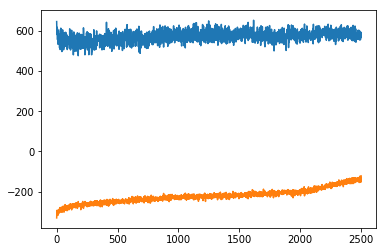

In [13]:
#plt.plot(net.train_loss)
plt.plot(-np.array(net.prior_loss))
plt.plot(np.array(net.variat_loss))
#plt.plot(-np.array(net.log_lik))
#plt.ylim(0, 1e8)
#plt.ylim(-35000, 0)%%

# Inference

In [14]:
#Training predictions
X_train_ = Variable(torch.Tensor(x_train))
samples_train = []

for i in range(100):
    preds = net.network.forward((X_train_), infer = False)
    samples_train.append(preds.detach().numpy()*y_std + y_mean)

samples_train = np.array(samples_train)
means_train = samples_train.mean(axis = 0)

#Test predictions
X_test_ = Variable(torch.Tensor(x_test))
samples_test = []

for i in range(100):
    preds = net.network((X_test_), infer = False)
    samples_test.append(preds.detach().numpy()*y_std + y_mean)
    
samples_test = np.array(samples_test)
means_test = samples_test.mean(axis = 0)

#Uncertainties
aleatoric_train = net.network.sigma_noise.detach().numpy()*y_std
epistemic_train = np.sqrt(samples_train.var(axis = 0))
epistemic_tr_gal = np.sqrt(1/samples_train.shape[0]*np.square(samples_train).sum(axis = 0) - \
(1/samples_train.shape[0]*samples_train.sum(axis = 0))**2)
total_unc_train = np.sqrt(aleatoric_train**2 + epistemic_train**2)

aleatoric_test = net.network.sigma_noise.detach().numpy()*y_std
epistemic_test = np.sqrt(samples_test.var(axis = 0))
total_unc_test = np.sqrt(aleatoric_test**2 + epistemic_test**2)

[172.12278089]


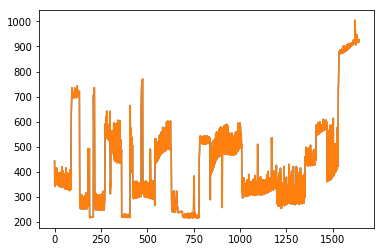

In [15]:
plt.plot(epistemic_tr_gal)
plt.plot(epistemic_train)
print (aleatoric_train)

In [16]:
x_train_plot = np.arange(0, int(x_train.shape[0]), step = 1)
x_test_plot = np.arange(0, int(x_test.shape[0]), step = 1)

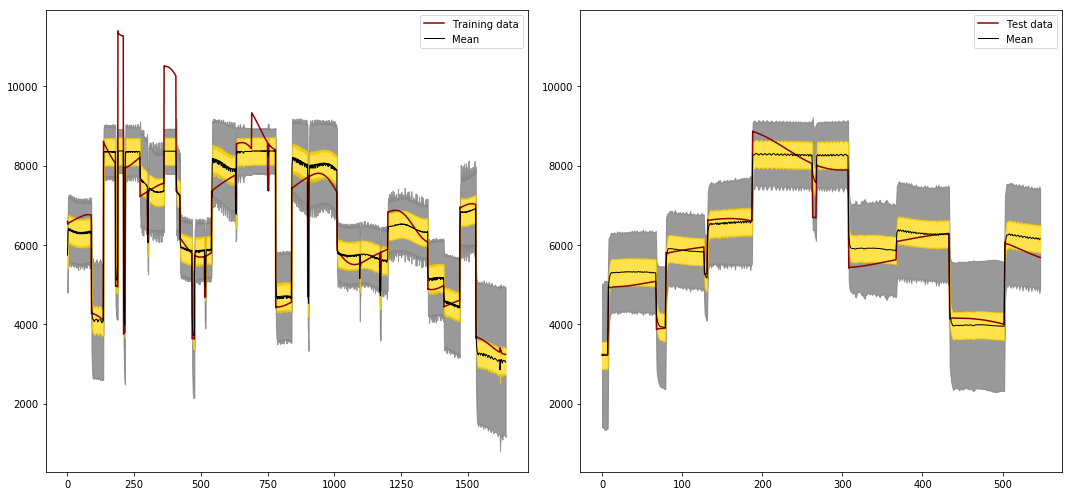

In [19]:
plot_BBP(x_train_plot.ravel(), Y_train.ravel(), x_test_plot.ravel(), Y_test.ravel(), means_train.ravel(), means_test.ravel(), \
         aleatoric_train, epistemic_train.ravel(), total_unc_train.ravel(), aleatoric_test, epistemic_test.ravel(), \
         total_unc_test.ravel())

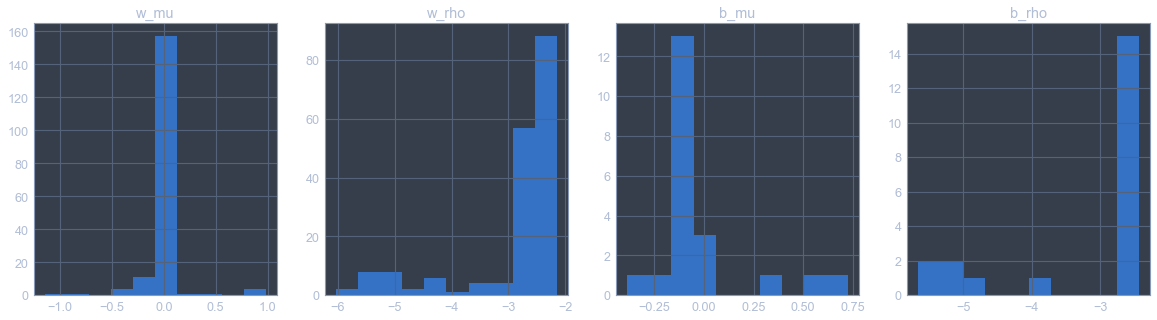

In [283]:
w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat = param_analysis(network = net)
param_plot(w_mu_flat, w_rho_flat, b_mu_flat, b_rho_flat)